In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import train_test_split

stores_train = pd.read_csv("data/stores_train.csv")
stores_test = pd.read_csv("data/stores_test.csv")
stores_train, stores_val = train_test_split(stores_train, test_size=0.2, random_state=0)

In [4]:
print(stores_train.shape)
stores_train.head()

(10287, 12)


,store_id,year,store_name,plaace_hierarchy_id,sales_channel_name,grunnkrets_id,address,lat,lon,chain_name,mall_name,revenue
2506,990857423-990974489-88185,2016,BAKER KLAUSEN UNION,1.2.2.0,Bakery shop,6020601,GRØNLAND 54,59.743135,10.194627,BAKER KLAUSEN DRAMMEN,NaN,4.447
12305,948879220-972145203-18800,2016,PRIKKEN RENS AS,3.4.2.0,Laundromats and dry cleaners,2350203,ENERGIVEGEN 5,60.149288,11.187290,NaN,NaN,2.040
4142,951136751-971668970-6795,2016,EXPERT HOKKSUND,2.3.1.0,Electronics stores,6240307,SUNDMOEN NÆRINGSOMRÅDE,59.768986,9.899066,EXPERT,NaN,36.489
8561,980237508-980246167-71346,2016,INVIT AS,2.9.1.0,Gifts and interior design shops,15040206,APOTEKERGATA 9,62.471607,6.151301,NaN,NaN,5.739
818,974421305-974489902-136560,2016,MUCHO MAS,1.1.6.2,Restaurants,3012312,THORVALD MEYERS GATE 36,59.924205,10.759401,NaN,NaN,15.573


In [5]:
print(stores_val.shape)
stores_val.head()

(2572, 12)


,store_id,year,store_name,plaace_hierarchy_id,sales_channel_name,grunnkrets_id,address,lat,lon,chain_name,mall_name,revenue
3039,915895964-916348282--916348282,2016,RED ZONE NIGHT CLUB AS,1.3.2.0,Pubs,16011204,FJORDGATA 60,63.434725,10.396415,NaN,NaN,0.830
11932,979136463-979138423-3267,2016,BRILLEHUSET OPTIKER GUTTORMSEN,3.3.5.0,Opticians,18330701,GAMMELVEIEN 11 B,66.340746,14.144399,ALLIANCE OPTIKK,NaN,2.866
5875,943486220-972604380-506,2016,G-SPORT RJUKAN,2.6.3.2,Sporting goods stores,8260308,SAM EYDES GATE 69,59.878475,8.588883,G-SPORT,NaN,7.537
4041,979875010-979921195-105878,2016,CIRCLE K STRANDA,2.2.1.0,Gas stations,15250107,SJØGATA 11,62.309373,6.948788,CIRCLE K DETALJIST,NaN,10.324
4477,990122873-984715021-68207,2016,B-YOUNG GJØVIK,2.4.1.0,Women’s clothing stores,5020403,STORGATA 3,60.795677,10.691018,B-YOUNG,NaN,3.855


In [6]:
print(stores_test.shape)
stores_test.head()

(8577, 11)


,store_id,year,store_name,plaace_hierarchy_id,sales_channel_name,grunnkrets_id,address,lat,lon,chain_name,mall_name
0,914206820-914239427-717245,2016,VÅLERENGA HALAL BURGER AS,1.1.1.0,Hamburger restaurants,3012704,STRØMSVEIEN 25 A,59.908672,10.787031,NaN,NaN
1,916789157-916823770-824309,2016,BURGER KING MYREN,1.1.1.0,Hamburger restaurants,8061401,MYREN 1,59.201467,9.588243,BURGER KING,NaN
2,913341082-977479363-2948,2016,BURGER KING STOVNER,1.1.1.0,Hamburger restaurants,3013917,STOVNER SENTER 3,59.962146,10.924524,BURGER KING,Stovner Senter
3,889682582-889697172-28720,2016,BURGER KING TUNGASLETTA,1.1.1.0,Hamburger restaurants,16012104,TUNGASLETTA 16,63.420785,10.461091,BURGER KING,NaN
4,997991699-998006945-417222,2016,VULKAN BURGERBAR,1.1.1.0,Hamburger restaurants,3014305,AUD SCHØNEMANNS VEI 15,59.921102,10.785123,VULKAN BURGERBAR,NaN


<AxesSubplot:xlabel='revenue', ylabel='Count'>

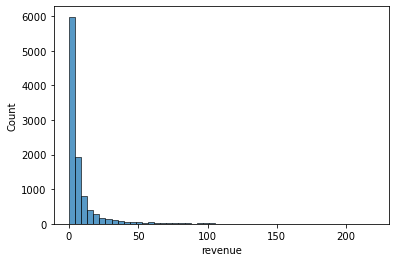

In [7]:
sns.histplot(data=stores_train['revenue'], bins=50)

### Investigating the different features

In [8]:
stores_train.dtypes

store_id                object
year                     int64
store_name              object
plaace_hierarchy_id     object
sales_channel_name      object
grunnkrets_id            int64
address                 object
lat                    float64
lon                    float64
chain_name              object
mall_name               object
revenue                float64
dtype: object

In [9]:
stores_train.describe()

,year,grunnkrets_id,lat,lon,revenue
count,10287.0,1.028700e+04,10287.000000,10287.000000,10287.000000
mean,2016.0,9.348313e+06,61.223094,10.005801,8.328546
std,0.0,5.794345e+06,2.969380,3.825401,15.659131
min,2016.0,1.010105e+06,57.994443,4.625889,0.000000
25%,2016.0,3.014302e+06,59.433541,7.223571,1.188000
50%,2016.0,9.065412e+06,59.941830,10.407527,3.363000
75%,2016.0,1.449020e+07,62.144366,10.850242,8.052500
max,2016.0,2.030031e+07,71.098287,31.118935,219.599000


store_id and year are redundant as they provide no information

In [10]:
stores_train["store_name"].nunique()


10265

Since there are so many unique store names, we omit this ATM

#### Plaace Hierarchy ID

In [11]:
stores_train["plaace_hierarchy_id"].value_counts()

3.2.4.0    959
2.8.1.0    879
2.4.6.0    700
3.2.1.0    605
1.1.6.2    499
          ... 
3.3.2.0      1
2.3.6.0      1
2.9.6.0      1
2.2.3.0      1
2.4.3.0      1
Name: plaace_hierarchy_id, Length: 88, dtype: int64

IDEA: split into 4 columns, first column contains only first number, second contains first two numbers...

IDEA: split the 4 numbers into 4 columns.

Treat as categorical variable

#### Sales Channel Name

In [12]:
stores_train["sales_channel_name"].value_counts()

Spas                       959
Grocery stores             879
Clothing stores            700
Hairdressers               605
Restaurants                499
                          ... 
Construction workers         1
Audio and video store        1
Carpet stores                1
Boating shops                1
Thrift shops - clothing      1
Name: sales_channel_name, Length: 88, dtype: int64

Contains same information as plaace hierarchy id, redundant

#### Grunnkrets ID

In [13]:
stores_train["grunnkrets_id"]

2506      6020601
12305     2350203
4142      6240307
8561     15040206
818       3012312
           ...   
4859     18330207
3264     16017522
9845     15040101
10799    12012008
2732     20120607
Name: grunnkrets_id, Length: 10287, dtype: int64

Simply a foreign key to link to the other CSV files, will look at it later

#### Address

In [14]:
stores_train["address"].nunique()

6880

#### Lat & Long

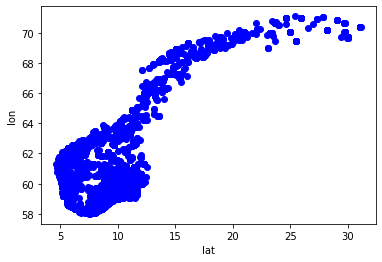

In [15]:
plt.plot(stores_train["lon"], stores_train["lat"], "bo")
plt.ylabel("lon")
plt.xlabel("lat")
plt.show();

#### Chain Name

In [16]:
# pd.set_option('display.max_rows', None)  # or 1000
stores_train["chain_name"].value_counts()

REMA FRANCHISE NORGE    223
JOKER                   132
BUNNPRIS                 96
CIRCLE K DETALJIST       94
MIX                      86
                       ... 
BAKERIET CAFEDRIFT        1
BILTEMA NORGE             1
COOP ANDRE                1
SOLHAGEN                  1
TORSHOV SPORT             1
Name: chain_name, Length: 294, dtype: int64

In [17]:
stores_train["chain_name"].isna().sum() / stores_train.shape[0]

0.7103139885292117

IMPUTE NANS: impute NANs as a category of its own. Can also treat the whole column as binary not-NAN/NAN. Can also decide threshold for when a chain becomes a NAN or another category altogether.

#### Mall Name

In [18]:
stores_train["mall_name"].value_counts().sum() / stores_train.shape[0]

0.17390881695343638

In [19]:
pd.set_option('display.max_rows', 500)
stores_train["mall_name"].value_counts()

Strømmen Storsenter               30
Amfi Moa                          22
Sandvika Storsenter               19
Kvadrat                           18
Jessheim Storsenter               15
Ski Storsenter                    14
Gulskogen Senter                  14
Amfi Borg                         13
Stovner Senter                    13
CC Gjøvik                         13
Lagunen Storsenter                13
Sørlandssenteret                  13
Amfi Finnsnes                     12
Amfi Madla                        12
CC Vest                           11
Torvbyen                          11
Herkules                          11
Knarvik Senter                    11
Storo Storsenter                  11
CC Hamar                          11
Triaden Lørenskog Storsenter      11
Vinterbro Senter                  11
Sartor Storsenter                 10
House of Oslo                     10
Vulkan                            10
Magasinet Drammen                 10
Amfi Førde                        10
J

Treat similarly to chain name, we think a binary approach would be the best as the size of a lot of malls seems to be wrong due to missing shops etc.

#### Revenue

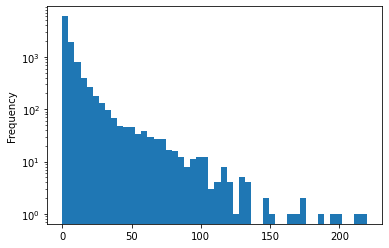

In [20]:
stores_train.revenue.plot.hist(bins=50, logy=True);

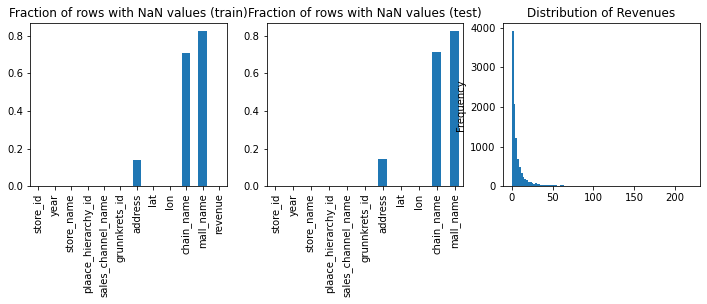

In [21]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(12, 3), ncols=3)
stores_train.isna().mean().plot.bar(ax=ax1)
ax1.set_title('Fraction of rows with NaN values (train)')
stores_test.isna().mean().plot.bar(ax=ax2)
ax2.set_title('Fraction of rows with NaN values (test)')
stores_train.revenue.plot.hist(bins=100, ax=ax3)
ax3.set_title('Distribution of Revenues');

## Preprocessing data & training model

We start by including lat, lon, chain_name, mall_name and plaace_hierarchy_id

In [22]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder

initial_predictors = ["lat", "lon", "plaace_hierarchy_id", "chain_name", "mall_name"]
final_predictors = initial_predictors.copy()
response = "revenue"

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(missing_values=np.nan, strategy="constant")),
        ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)),
    ]
)
categorical_features = ["plaace_hierarchy_id", "chain_name", "mall_name"]

#numerical_transformer = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
#numerical_features = [""]


preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_features),
#        ("num", numerical_transformer, numerical_features),
    ]
)

model = Pipeline(
    steps=[
        ("preprocessor", preprocessor), 
        ("classifier", RandomForestRegressor(max_depth=4, random_state=0))
    ]
)

X_train = stores_train[initial_predictors]
y_train = stores_train[response]

X_val = stores_val[initial_predictors]
y_val = stores_val[response]


In [23]:
# Adding a column for whether the values in address, chain and mall were None/NaN. Including this in the
# prediction yielded no increase

cols_with_missing = [col for col in stores_train
                     if stores_train[col].isnull().any()]

for col in cols_with_missing:
    X_train[col + '_was_missing'] = stores_train[col].isna()
    X_val[col + '_was_missing'] = stores_val[col].isna()
    final_predictors.append(col + '_was_missing')

/tmp/ipykernel_42260/500277625.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[col + '_was_missing'] = stores_train[col].isna()
/tmp/ipykernel_42260/500277625.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_val[col + '_was_missing'] = stores_val[col].isna()
/tmp/ipykernel_42260/500277625.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

In [24]:
X_train[final_predictors].head()

,lat,lon,plaace_hierarchy_id,chain_name,mall_name,address_was_missing,chain_name_was_missing,mall_name_was_missing
2506,59.743135,10.194627,1.2.2.0,BAKER KLAUSEN DRAMMEN,NaN,False,False,True
12305,60.149288,11.187290,3.4.2.0,NaN,NaN,False,True,True
4142,59.768986,9.899066,2.3.1.0,EXPERT,NaN,False,False,True
8561,62.471607,6.151301,2.9.1.0,NaN,NaN,False,True,True
818,59.924205,10.759401,1.1.6.2,NaN,NaN,False,True,True


In [25]:
pipe = model.fit(X_train[final_predictors], y_train)
y_pred = pipe.predict(X_val[final_predictors])

In [26]:
from RMSLE import rmsle

rmsle(y_pred=y_pred, y_true=y_val)

0.8817201388312189

Tried to do some feature importance, but unsure of how well this works for RandomForestRegressor (also very few values got an importance rating?)

In [27]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_val.columns, model.steps[1][1].feature_importances_):
    feats[feature] = importance #add the name/value pair 
feats

{'lat': 0.10378845377059273,
 'lon': 0.8873470865516377,
 'plaace_hierarchy_id': 0.008864459677769504}

## Creating the submission

In [28]:
# Predict on the test set 
final_predictors = final_predictors.copy()
final_predictors.append("store_id")
X_test = stores_test[final_predictors].copy()
y_test_pred = model.predict(X_test)

# Generate submission dataframe 
# NOTE: It is important that the ID and predicted values match
submission = pd.DataFrame()
submission['id'] = X_test.store_id 
submission['predicted'] = np.asarray(y_test_pred)

# Save it to disk (`index=False` means don't save the index in the csv)
submission.to_csv('submission.csv', index=False)
submission

KeyError: "['address_was_missing', 'chain_name_was_missing', 'mall_name_was_missing'] not in index"